In [5]:
import pandas as pd
import re 
from pprint import pprint

# Gensim for topic modeling
import gensim
from gensim.utils import simple_preprocess
from gensim import matutils, models
import gensim.corpora as corpora
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models # don't skip this
pyLDAvis.enable_notebook()
import matplotlib.pyplot as plt
%matplotlib inline

# Creating tf-idf model
from gensim import corpora, models

import warnings
warnings.filterwarnings('ignore')

### Testing on Twitter Data

In [6]:
twitter_df = pd.read_csv('C:/Users/limst/Documents/Big Data/Project/BDA/cleaned_twitter.csv')
twitter_df.head()

,Unnamed: 0,user_name,text,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,hashtags,source,text_split,text_contain_academic,hashtags_contain_academic
0,13,CryptoFond4FUN,"wow, that was a very good answer!\n#chatgpt #a...",Currently: The Blue Planet.,Blue belt on the blockchain! More to learn.\np...,2022-11-19 20:19:48+00:00,41.0,250.0,554,False,2023-03-08 14:24:26+00:00,"['chatgpt', 'ai', 'machinelearning', 'universe...",Twitter Web App,"['wow,', 'that', 'was', 'a', 'very', 'good', '...",True,True
1,32,AI Expert,a new ai tool that is special for #womansday #...,NaN,About artificial intelligence,2014-07-05 09:20:43+00:00,467.0,246.0,11,False,2023-03-08 14:17:48+00:00,"['womansday', '8marchwomensday', '8mars2023', ...",Twitter for iPhone,"['a', 'new', 'ai', 'tool', 'that', 'is', 'spec...",True,True
2,44,TechWite,"🤣 #chatgpt ""what could possibly go wrong?"" we'...",NaN,"News of interest about IOS, Macs, Mobility, an...",2013-01-21 04:04:35+00:00,26.0,117.0,48,False,2023-03-08 14:14:43+00:00,"['chatgpt', 'bewaretheinternet']",LinkedIn,"['🤣', '#chatgpt', '""what', 'could', 'possibly'...",True,True
3,59,Cassia,#internationalwomensday: schoolgirls poisoned ...,"Penryn, England",PhD Cand. @UniExeCornwall-Interdisc. Mining En...,2012-01-10 22:32:49+00:00,400.0,780.0,3236,False,2023-03-08 14:09:17+00:00,"['internationalwomensday', 'iranianschoolgirls']",Twitter Web App,"['#internationalwomensday:', 'schoolgirls', 'p...",True,True
4,103,Olivier Berard,teachers are using #chatgpt more than students...,Paris France,"Transformation Digitale, Workplace, Expérience...",2009-07-02 08:39:27+00:00,3466.0,967.0,19161,False,2023-03-08 14:00:29+00:00,"['chatgpt', 'learning']",Twitter for Android,"['teachers', 'are', 'using', '#chatgpt', 'more...",True,True


### Creating the corpus

In [13]:
# change twitter text to list
def str_to_list(text):
    text = text[1:len(text)-1]
    text_list = text.split(',')
    text_list = [text.strip()[1:-1] for text in text_list]
    return text_list

In [14]:
data_lemmatized = twitter_df['text_split'].tolist()
data_lemmatized = [str_to_list(text) for text in data_lemmatized]
data_lemmatized[:10]

[['wo',
  '',
  'that',
  'was',
  'a',
  'very',
  'good',
  'answer!',
  '#chatgpt',
  '#ai',
  '#machinelearning',
  '#universe',
  '#cosmology',
  '#physics',
  'https://t.co/mhzvjw2cu3'],
 ['a',
  'new',
  'ai',
  'tool',
  'that',
  'is',
  'special',
  'for',
  '#womansday',
  '#8marchwomensday',
  '#8mars2023',
  '#iwd2023',
  '#midjourney',
  '#chatgpt',
  '#worldwomenday',
  'https://t.co/2ecdqpzxvh'],
 ['🤣',
  '#chatgpt',
  '"what',
  'could',
  'possibly',
  'go',
  'wrong?"',
  "we're",
  'going',
  'to',
  'find',
  'out.',
  '#bewaretheinternet',
  'https://t.co/bqriwrqa1u'],
 ['#internationalwomensday:',
  'schoolgirls',
  'poisoned',
  '#iranianschoolgirls;',
  'the',
  'most',
  'influential',
  'country',
  'bans',
  'abortions',
  '#roevwade;',
  '#transphobia',
  'is',
  'on',
  'the',
  'rise.',
  'even',
  'the',
  'robots',
  'are',
  'sexist',
  '#chatgpt.',
  "i'm",
  'tired',
  '&amp;',
  'sa',
  '',
  'but',
  'i',
  "can't",
  'retire',
  'until',
  "i'm",


In [15]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Filter out tokens that appear in only 1 documents and appear in more than 90% of the documents
id2word.filter_extremes(no_below=2, no_above=0.9)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [16]:
# Create a dictionary representation of the documents. Each word gets an id
print('Sample word to id mappings:\n', list(id2word.items())[:50])
print()
print('Total Vocabulary Size:', len(id2word))

Sample word to id mappings:
 [(0, ''), (1, '#ai'), (2, '#cosmology'), (3, '#machinelearning'), (4, '#physics'), (5, '#universe'), (6, 'a'), (7, 'answer!'), (8, 'good'), (9, 'that'), (10, 'very'), (11, 'was'), (12, 'wo'), (13, '#8marchwomensday'), (14, '#iwd2023'), (15, '#midjourney'), (16, '#womansday'), (17, 'ai'), (18, 'for'), (19, 'is'), (20, 'new'), (21, 'special'), (22, 'tool'), (23, '"what'), (24, 'could'), (25, 'find'), (26, 'go'), (27, 'going'), (28, 'out.'), (29, 'possibly'), (30, 'to'), (31, "we're"), (32, '🤣'), (33, '#chatgpt.'), (34, '&amp;'), (35, '105'), (36, 'are'), (37, 'bans'), (38, 'but'), (39, "can't"), (40, 'country'), (41, 'do'), (42, 'even'), (43, 'i'), (44, "i'm"), (45, 'influential'), (46, 'lot'), (47, 'more'), (48, 'most'), (49, 'on')]

Total Vocabulary Size: 47462


### Build LDA Model

In [17]:
# supporting function
def compute_evaluation_values(corpus, dictionary, k):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    perplexity = lda_model.log_perplexity(corpus)
    
    return [coherence_model_lda.get_coherence(), perplexity]

In [18]:
# Iterate over possible number of topics.
topic_param = []
coherence_score = []
perplexity_score = []

for k in range(2, 20):
    print('topic number: ', k)
    ev = compute_evaluation_values(corpus=corpus, dictionary=id2word, k=k)
    coherence_score.append(ev[0])
    perplexity_score.append(ev[1])
    print('Coherence Score: ', ev[0])
    print('Perplexity Score: ', ev[1])
    print()
    
    topic_param.append(k)

topic number:  2
Coherence Score:  0.4098321643203658
Perplexity Score:  -7.560471015034239

topic number:  3
Coherence Score:  0.38025223054810176
Perplexity Score:  -7.560024233467331

topic number:  4
Coherence Score:  0.4768659049249856
Perplexity Score:  -7.571923089244832

topic number:  5
Coherence Score:  0.37598188419252637
Perplexity Score:  -7.614999045741407

topic number:  6
Coherence Score:  0.4274611431611815
Perplexity Score:  -7.664248801745484

topic number:  7
Coherence Score:  0.4503739054609433
Perplexity Score:  -7.766273887633151

topic number:  8
Coherence Score:  0.45820007531002116
Perplexity Score:  -7.920810838303099

topic number:  9
Coherence Score:  0.44224778053524305
Perplexity Score:  -8.14543916671165

topic number:  10
Coherence Score:  0.44834446192897326
Perplexity Score:  -8.51083905875165

topic number:  11
Coherence Score:  0.433195386742244
Perplexity Score:  -9.000401272358813

topic number:  12
Coherence Score:  0.4538477038357529
Perplexity 

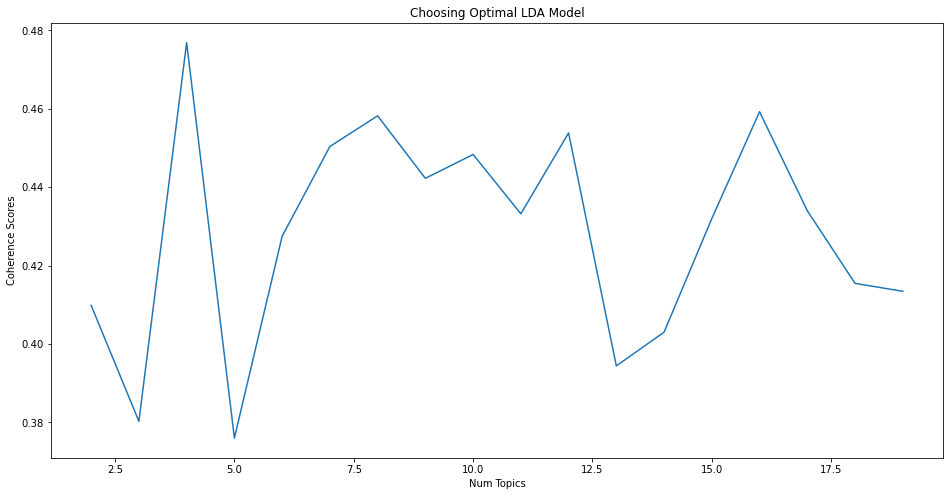

In [19]:
# Show graph
plt.figure(figsize=(16, 8))
plt.plot(topic_param, coherence_score)

plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Coherence Scores")
plt.show()

### Final LDA Model

In [20]:
ntopics = 4

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=ntopics, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [21]:
# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.045*"#ai" + 0.031*"#machinelearning" + 0.026*"#artificialintelligence" + '
  '0.019*"#openai" + 0.012*"#deeplearning" + 0.010*"for" + 0.010*"#technology" '
  '+ 0.009*"#tech" + 0.008*"-" + 0.008*"chatgpt"'),
 (1,
  '0.017*"#ai" + 0.009*"#midjourney" + 0.009*"#aiart" + 0.009*"#nft" + '
  '0.007*"#nftcommunity" + 0.007*"for" + 0.007*"the" + 0.006*"project" + '
  '0.006*"life" + 0.005*"#art"'),
 (2,
  '0.036*"to" + 0.034*"the" + 0.034*"" + 0.025*"a" + 0.025*"and" + 0.019*"of" '
  '+ 0.017*"is" + 0.016*"it" + 0.014*"i" + 0.013*"in"'),
 (3,
  '0.050*"the" + 0.033*"" + 0.026*"of" + 0.019*"in" + 0.018*"and" + 0.017*"to" '
  '+ 0.016*"is" + 0.014*"a" + 0.013*"on" + 0.010*"chatgpt"')]


In [22]:
def Sort_Tuple(tup):  
    return(sorted(tup, key = lambda x: x[1], reverse = True))

In [24]:
doc_num, topic_num, prob = [], [], []
print(lda_model.get_document_topics(corpus))
for n in range(len(twitter_df)):
    get_document_topics = lda_model.get_document_topics(corpus[n])
    doc_num.append(n)
    sorted_doc_topics = Sort_Tuple(get_document_topics)
    topic_num.append(sorted_doc_topics[0][0])
    prob.append(sorted_doc_topics[0][1])

In [25]:
twitter_df['Doc'] = doc_num
twitter_df['Topic'] = topic_num
twitter_df['Probability'] = prob

In [26]:
final = twitter_df[['user_name', 'text', 'user_location', 'Doc', 'Topic', 'Probability']]
final.head()

,user_name,text,user_location,Doc,Topic,Probability
0,CryptoFond4FUN,"wow, that was a very good answer!\n#chatgpt #a...",Currently: The Blue Planet.,0,2,0.582379
1,AI Expert,a new ai tool that is special for #womansday #...,NaN,1,3,0.795650
2,TechWite,"🤣 #chatgpt ""what could possibly go wrong?"" we'...",NaN,2,2,0.931486
3,Cassia,#internationalwomensday: schoolgirls poisoned ...,"Penryn, England",3,2,0.977990
4,Olivier Berard,teachers are using #chatgpt more than students...,Paris France,4,2,0.922982


### Model Evaluation

In [27]:
# Compute Perplexity
perplexity = lda_model.log_perplexity(corpus)
print('Perplexity: ', perplexity)  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Perplexity:  -7.566950590605847
Coherence Score:  0.47772413579117073


### Visualisation

In [29]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.207172  0.072636       1        1  63.414452
3      0.168588  0.007392       2        1  20.427819
0     -0.113697 -0.251183       3        1  10.256789
1     -0.262063  0.171155       4        1   5.900939, topic_info=                        Term          Freq         Total Category  logprob  \
1                        #ai  17019.000000  17019.000000  Default  30.0000   
55                       the  53096.000000  53096.000000  Default  29.0000   
3           #machinelearning   5104.000000   5104.000000  Default  28.0000   
0                             45702.000000  45702.000000  Default  27.0000   
121  #artificialintelligence   5639.000000   5639.000000  Default  26.0000   
..                       ...           ...           ...      ...      ...   
617                      who    322.685875   1693.047802   Topic4  -5.6921   
614                       me    343.343571   3001.816322   Topic4  -5.6300   
17                        ai    382.845707  10220.602307   Topic4  -5.5211   
30                        to    426.137065  43899.008492   Topic4  -5.4140   
75                       you    315.382640   9247.737640   Topic4  -5.7150   

     loglift  
1    30.0000  
55   29.0000  
3    28.0000  
0    27.0000  
121  26.0000  
..       ...  
617   1.1725  
614   0.6618  
17   -0.4545  
30   -1.8048  
75   -0.5483  

[264 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
0         1  0.758333                
0         2  0.236900                
0         3  0.000241                
0         4  0.004551                
317       3  0.999012  #100daysofcode
...     ...       ...             ...
110       2  0.866623               |
110       3  0.088302               |
110       4  0.044782               |
4938      2  0.996229               •
1145      2  0.997727               🚀

[343 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 1, 2])

### Word Count of Topic Keywords

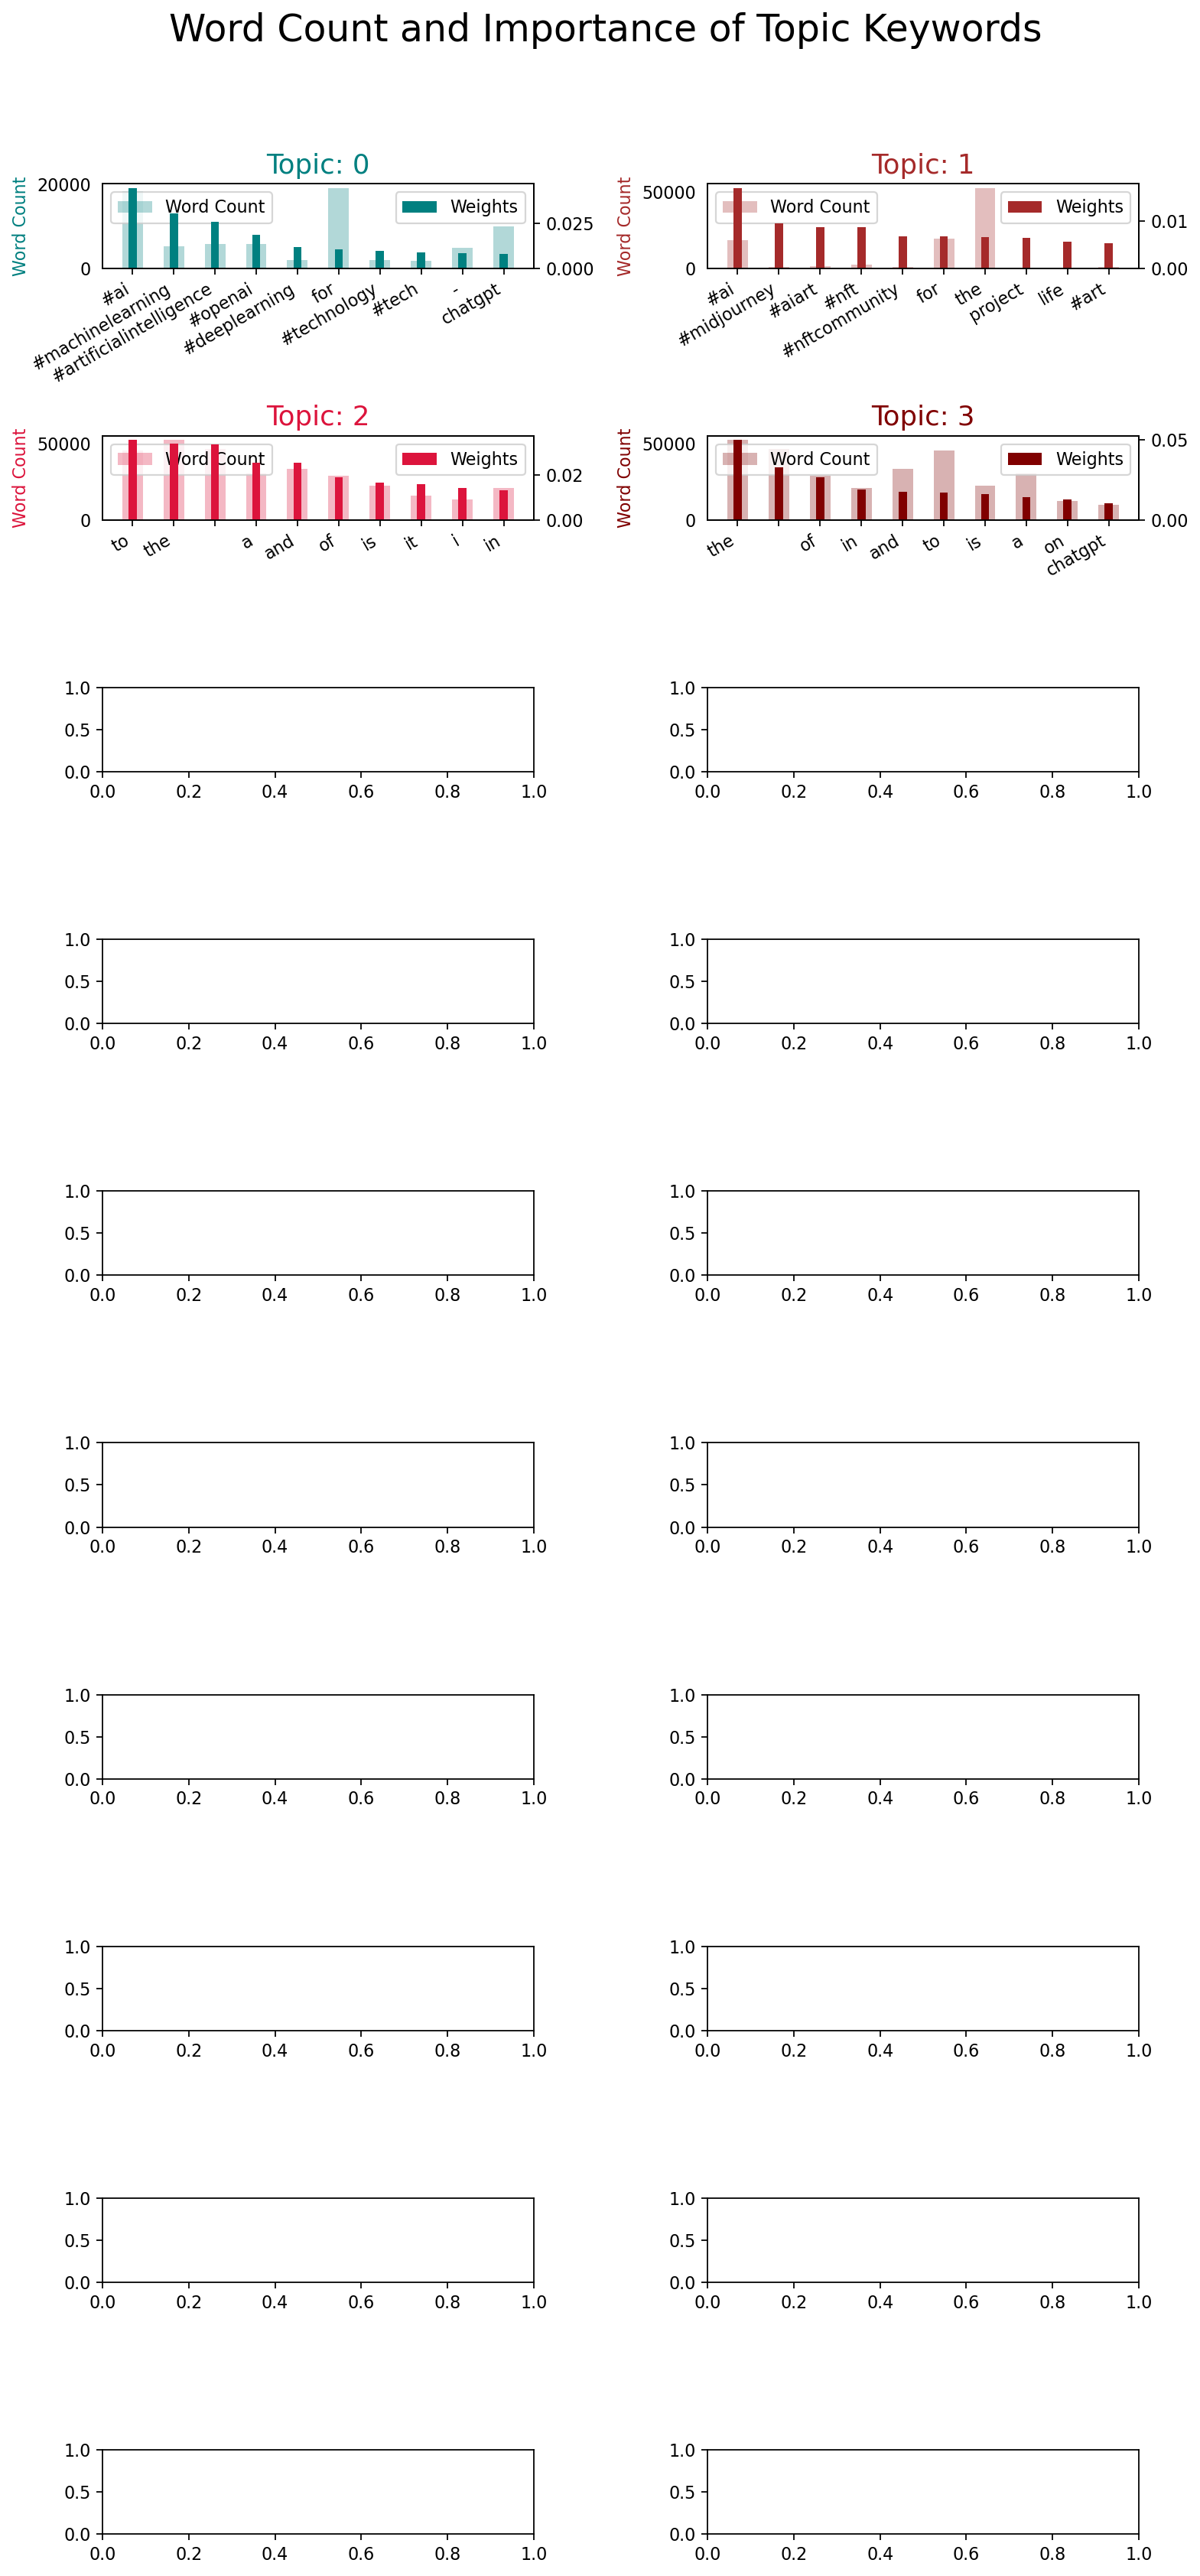

In [30]:
from collections import Counter

topics = lda_model.show_topics(num_topics=ntopics, formatted=False)
data_flat = [w for w_list in data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(10, 2, figsize=(10,20), dpi=160)
cols = ['#008080', '#A52A2A', '#DC143C', '#800000', '#006400', '#556b2f', '#002366', '#ff8c00', '#FF1493', '#9400D3',
        '#ba55d3', '#b8860b', '#C71585', '#00ff7f', '#00004C', '#00008B', '#B8860B', '#DEB887', '#8A2BE2', '#1b364a']

for i, ax in enumerate(axes.flatten()):
    if i > ntopics - 1: # break when all topics are shown
        break
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')


fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()